## Strategies

You can initilize a strategy by R language.

The main libraries are

* [Quantmod](https://www.quantmod.com/) ([doc](https://www.rdocumentation.org/packages/quantmod/)), for loading data and managing the strategy
* [QuantStrat](https://www.rdocumentation.org/packages/quantstrat/), for managing the strategy
* [PerformanceAnalytics](https://www.rdocumentation.org/packages/PerformanceAnalytics/), for performance and risk analysis

### How to load indicators on your strategy

In [1]:
#install.packages("quantmod")
#require(devtools)
#devtools::install_github("braverock/blotter")
#devtools::install_github("braverock/quantstrat")

In [2]:
library(quantmod)
# initialization
Sys.setenv(TZ="UTC")
symbol = as.character("AMZN")
start <- as.Date("2017-01-01")
end <- as.Date("2020-01-01")
getSymbols(Symbols = symbol, src = "yahoo", from = start, to = end)

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

‘getSymbols’ currently uses auto.assign=TRUE by default, but will
use auto.assign=FALSE in 0.5-0. You will still be able to use
‘loadSymbols’ to automatically load data. getOption("getSymbols.env")
and getOption("getSymbols.auto.assign") will still be checked for
alternate defaults.

This message is shown once per session and may be disabled by setting 
options("getSymbols.warning4.0"=FALSE). See ?getSymbols for details.




[1] "AMZN"

In [3]:
AMZN <- na.omit(lag(AMZN))
# calculate indicators
sma20 <- SMA(Cl(AMZN), n = 20)
ema20 <- EMA(Cl(AMZN), n = 20)

In [4]:
library(quantstrat)
# strategy initialization
currency("USD")
stock(symbol, currency = 'USD', multiplier = 1)
tradeSize <- 100000
initEquity <- 100000
account.st <- portfolio.st <- strategy.st <- "my strategy"
rm.strat("my strategy")
out <- initPortf(portfolio.st, symbols = symbol, initDate = start, currency = "USD")
out <- initAcct(account.st, portfolios = portfolio.st, initDate = start, currency = "USD", initEq = initEquity)
initOrders(portfolio.st, initDate = start)
strategy(strategy.st, store = TRUE)

Loading required package: blotter

Loading required package: FinancialInstrument

Loading required package: PerformanceAnalytics


Attaching package: ‘PerformanceAnalytics’


The following object is masked from ‘package:graphics’:

    legend


Loading required package: foreach



[1] "USD"

[1] "AMZN"

In [5]:
# indicators with QuantStrat
out <- add.indicator(strategy.st, name = "SMA", arguments = list(x = quote(Cl(AMZN)), n = 20, maType = "SMA"), label = "SMA20periods")
out <- add.indicator(strategy.st, name = "SMA", arguments = list(x = quote(Cl(AMZN)), n = 50, maType = "SMA"), label = "SMA50periods")
out <- add.indicator(strategy.st, name = "EMA", arguments = list(x = quote(Cl(AMZN)), n = 20, maType = "EMA"), label = "EMA20periods")
out <- add.indicator(strategy.st, name = "EMA", arguments = list(x = quote(Cl(AMZN)), n = 50, maType = "EMA"), label = "EMA50periods")
out <- add.indicator(strategy.st, name = "RSI", arguments = list(price = quote(Cl(AMZN)), n = 7), label = "RSI720periods")
out <- add.indicator(strategy.st, name = "BBands", arguments = list(HLC = quote(Cl(AMZN)), n = 20, maType = "SMA", sd = 2), label = "Bollinger Bands")

In [6]:
# custom indicator
RSIaverage <- function(price, n1, n2) {
    RSI_1 <- RSI(price = price, n = n1)
    RSI_2 <- RSI(price = price, n = n2)
    calculatedAverage <- (RSI_1 + RSI_2) / 2
    colnames(calculatedAverage) <- "RSI_average"
    return(calculatedAverage)
}
out <- add.indicator(strategy.st, name = "RSIaverage", arguments = list(price = quote(Cl(AMZN)), n1 = 7, n2 = 14), label = "RSIaverage")

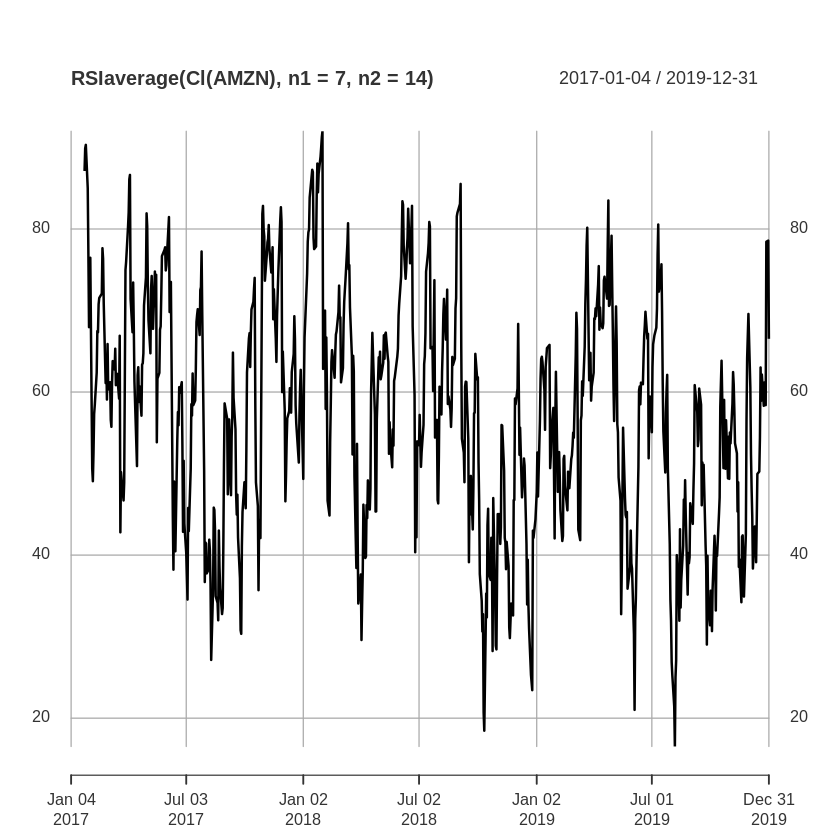

In [7]:
# first tests 
plot(RSIaverage(Cl(AMZN), n1=7, n2=14)) # for graphing your function results

In [8]:
# load all indicators on my data
test <- applyIndicators(strategy = strategy.st, mktdata = OHLC(AMZN))
subsetTest <- test["2018-01-01/2019-01-01"]
head(subsetTest)

           AMZN.Open AMZN.High AMZN.Low AMZN.Close SMA.SMA20periods
2018-01-02   1182.35   1184.00  1167.50    1169.47         1168.841
2018-01-03   1172.00   1190.00  1170.51    1189.01         1170.174
2018-01-04   1188.30   1205.49  1188.30    1204.20         1173.687
2018-01-05   1205.00   1215.87  1204.66    1209.59         1177.088
2018-01-08   1217.51   1229.14  1210.00    1229.14         1180.927
2018-01-09   1236.00   1253.08  1232.03    1246.87         1185.281
           SMA.SMA50periods EMA.EMA20periods EMA.EMA50periods rsi.RSI720periods
2018-01-02         1129.739         1168.779         1130.025          44.92805
2018-01-03         1133.787         1170.706         1132.338          60.65982
2018-01-04         1138.213         1173.896         1135.156          68.75469
2018-01-05         1143.078         1177.295         1138.075          71.20734
2018-01-08         1148.143         1182.233         1141.646          78.38659
2018-01-09         1153.622         1188.389

### How to load signals on your strategy

The best practice is to prepare one column for each signal that you want to use on your strategy. The strategy below use the moving averages that they are SMA and EMA. You can use one or the other.

#### Disclaimer

The strategies below are some simple samples for having an idea how to use the libraries: those strategies are for the educational purpose only. All investments and trading in the stock market involve risk: any decisions related to buying/selling of stocks or other financial instruments should only be made after a thorough research, backtesting, running in demo and seeking a professional assistance if required.

#### Moving Average Crossover Strategy - Sample 1

* when the price value crosses the MA value from below, it will close any existing short position and go long (buy) one unit of the asset
* when the price value crosses the MA value from above, it will close any existing long position and go short (sell) one unit of the asset

Reference: https://www.learndatasci.com/tutorials/python-finance-part-3-moving-average-trading-strategy/

In [9]:
# Moving Average Crossover Strategy - Sample 1
signalPosition <- function(price, ma) {
    # Taking the difference between the prices and the MA timeseries
    price_ma_diff <- price - ma
    price_ma_diff[is.na(price_ma_diff)] <- 0 # replace missing signals with no position
    # Taking the sign of the difference to determine whether the price or the MA is greater
    position <- diff(price_ma_diff)
    position[is.na(position)] <- 0 # replace missing signals with no position
    colnames(position) <- "Signal_position"
    return(position)
}

In [10]:
#out <- add.indicator(strategy.st, name = "signalPosition", arguments = list(price = Cl(AMZN), ma = sma20), label = "signalPosition")
out <- add.indicator(strategy.st, name = "signalPosition", arguments = list(price = Cl(AMZN), ma = ema20), label = "signalPosition1")
out <- add.signal(strategy.st, name = "sigThreshold", arguments = list(column = "Signal_position", threshold = 2, relationship = "gte", cross = TRUE), label = "buy1")
out <- add.signal(strategy.st, name = "sigThreshold", arguments = list(column = "Signal_position", threshold = -2, relationship = "lte", cross = TRUE), label = "sell1")
#add.signal(strategy.st, name = "sigThreshold", arguments = list(data = position, column = "AMZN.Close", threshold = 2, relationship = "gte", cross = TRUE), label = "buy1")
#add.signal(strategy.st, name = "sigThreshold", arguments = list(data = position, column = "AMZN.Close", threshold = -2, relationship = "lte", cross = TRUE), label = "sell1")
# Creating rules
out <- add.rule(strategy.st, name = 'ruleSignal', arguments = list(sigcol = "buy1", sigval = TRUE, orderqty = 100, ordertype = 'market', orderside = 'long'), type = 'enter')
out <- add.rule(strategy.st, name = 'ruleSignal', arguments = list(sigcol = "sell1", sigval = TRUE, orderqty = 'all', ordertype = 'market', orderside = 'long'), type = 'exit')
#out <- add.rule(strategy.st, name = 'ruleSignal', arguments = list(sigcol = "sell1", sigval = TRUE, orderqty = -100, ordertype = 'market', orderside = 'short'), type = 'enter')
#out <- add.rule(strategy.st, name = 'ruleSignal', arguments = list(sigcol = "buy1", sigval = TRUE, orderqty = 'all', ordertype = 'market', orderside = 'short'), type = 'exit')

[1] "2017-02-02 00:00:00 AMZN 100 @ 832.349976"
[1] "2017-02-07 00:00:00 AMZN -100 @ 807.640015"
[1] "2017-02-09 00:00:00 AMZN 100 @ 819.710022"
[1] "2017-02-14 00:00:00 AMZN 100 @ 836.530029"
[1] "2017-02-17 00:00:00 AMZN 100 @ 844.140015"
[1] "2017-02-23 00:00:00 AMZN 100 @ 855.609985"
[1] "2017-02-24 00:00:00 AMZN -400 @ 852.190002"
[1] "2017-03-01 00:00:00 AMZN 100 @ 845.039978"
[1] "2017-03-02 00:00:00 AMZN -100 @ 853.080017"
[1] "2017-03-03 00:00:00 AMZN 100 @ 848.909973"
[1] "2017-03-06 00:00:00 AMZN -100 @ 849.880005"
[1] "2017-03-10 00:00:00 AMZN 100 @ 853"
[1] "2017-03-16 00:00:00 AMZN -100 @ 852.969971"
[1] "2017-03-22 00:00:00 AMZN 100 @ 843.200012"
[1] "2017-03-23 00:00:00 AMZN -100 @ 848.059998"
[1] "2017-03-24 00:00:00 AMZN 100 @ 847.380005"
[1] "2017-03-30 00:00:00 AMZN 100 @ 874.320007"
[1] "2017-04-04 00:00:00 AMZN 100 @ 891.51001"
[1] "2017-04-06 00:00:00 AMZN 100 @ 909.280029"
[1] "2017-04-10 00:00:00 AMZN -400 @ 894.880005"
[1] "2017-04-12 00:00:00 AMZN 100 @ 902.3

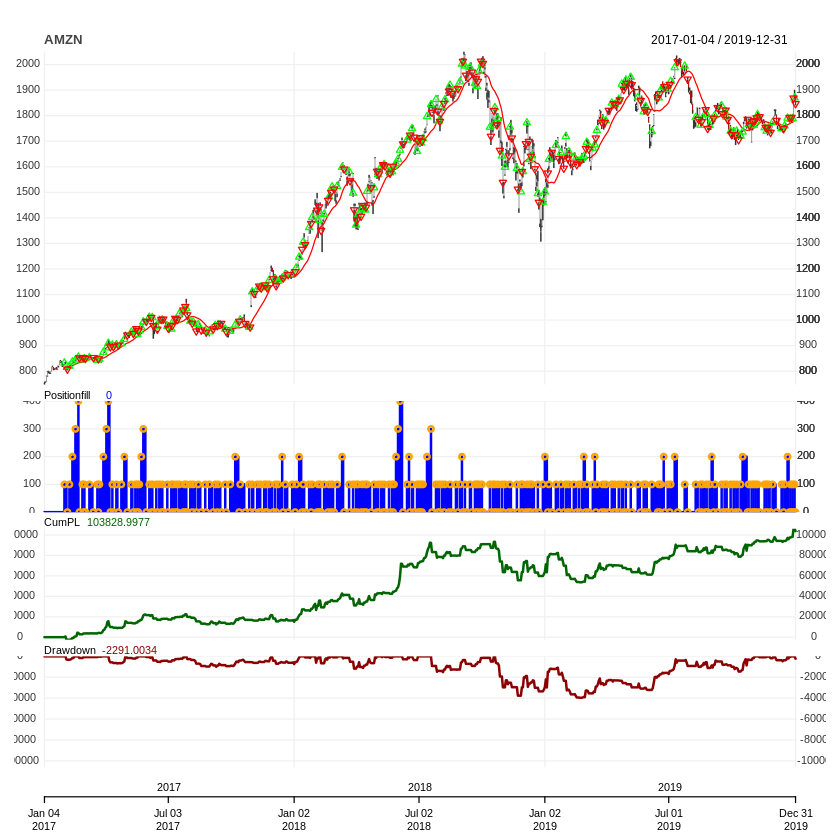

In [11]:
# backtesting
applyStrategy(strategy.st, portfolios=portfolio.st)
out <- updatePortf(portfolio.st)
dateRange <- time(getPortfolio(portfolio.st)$summary)[-1]
out <- updateAcct(portfolio.st, dateRange)
out <- updateEndEq(account.st)
chart.Posn(portfolio.st, Symbol=symbol, TA=c("add_SMA(n=20,col='red')"))

In [12]:
tstats <- tradeStats(portfolio.st, use="trades", inclZeroDays=FALSE)
data.frame(t(tstats))

,AMZN
,<chr>
Portfolio,my strategy
Symbol,AMZN
Num.Txns,348
Num.Trades,160
Net.Trading.PL,103829
Avg.Trade.PL,648.9312
Med.Trade.PL,194.4946
Largest.Winner,24637.02
Largest.Loser,-12510.01


In [13]:
#install.packages("magrittr") # package installations are only needed the first time you use it
#install.packages("dplyr")    # alternative installation of the %>%
library(magrittr) # needs to be run every time you start R and want to use %>%
library(dplyr)    # alternatively, this also loads %>%
trades <- tstats %>%
    mutate(Trades = Num.Trades, 
        Win.Percent = Percent.Positive, 
        Loss.Percent = Percent.Negative, 
        WL.Ratio = Percent.Positive/Percent.Negative) %>%
    select(Trades, Win.Percent, Loss.Percent, WL.Ratio)
data.frame(t(trades))


Attaching package: ‘dplyr’


The following objects are masked from ‘package:xts’:

    first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




,t.trades.
,<dbl>
Trades,160.000000
Win.Percent,53.125000
Loss.Percent,46.875000
WL.Ratio,1.133333


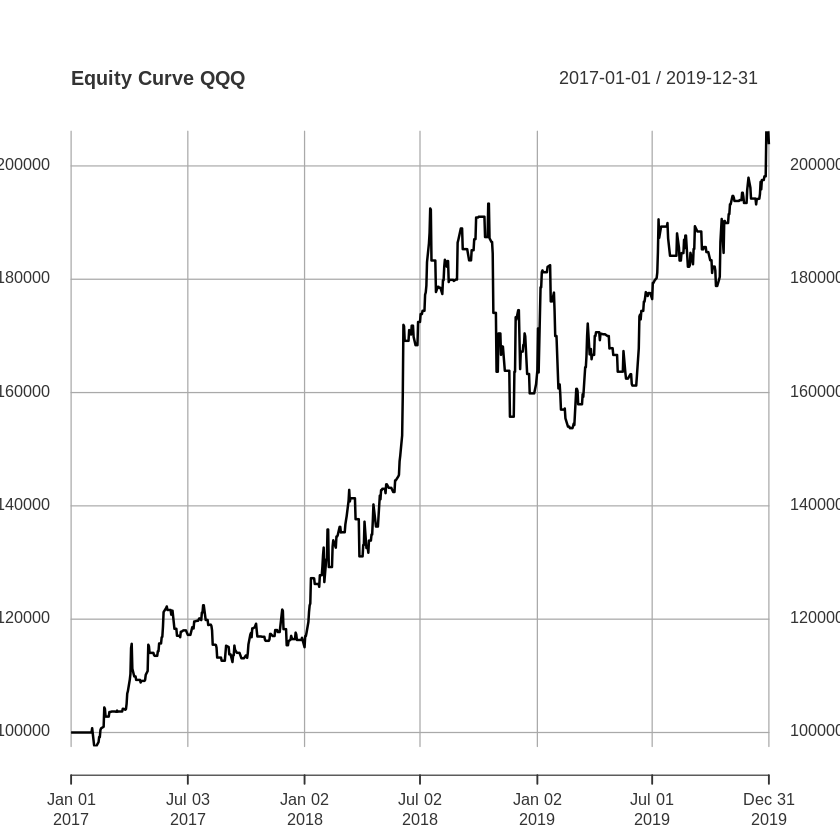

In [14]:
a <- getAccount(account.st)
equity <- a$summary$End.Eq
plot(equity, main = "Equity Curve QQQ")

In [15]:
portfolio <- getPortfolio(portfolio.st)
portfolioSummary <- portfolio$summary
colnames(portfolio$summary)
tail(portfolio$summary)

[1] "Long.Value"           "Short.Value"          "Net.Value"           
[4] "Gross.Value"          "Period.Realized.PL"   "Period.Unrealized.PL"
[7] "Gross.Trading.PL"     "Txn.Fees"             "Net.Trading.PL"

           Long.Value Short.Value Net.Value Gross.Value Period.Realized.PL
2019-12-23     178650           0    178650      178650              0.000
2019-12-24          0           0         0           0            650.000
2019-12-26     178921           0    178921      178921              0.000
2019-12-27          0           0         0           0           7956.006
2019-12-30     186980           0    186980      186980              0.000
2019-12-31          0           0         0           0          -2291.003
           Period.Unrealized.PL Gross.Trading.PL Txn.Fees Net.Trading.PL
2019-12-23                    0            0.000        0          0.000
2019-12-24                    0          650.000        0        650.000
2019-12-26                    0            0.000        0          0.000
2019-12-27                    0         7956.006        0       7956.006
2019-12-30                    0            0.000        0          0.000
2019-12-31                    0      

                 End.Eq
2019-12-23  0.000000000
2019-12-24  0.003285503
2019-12-26  0.000000000
2019-12-27  0.039363582
2019-12-30  0.000000000
2019-12-31 -0.011177133

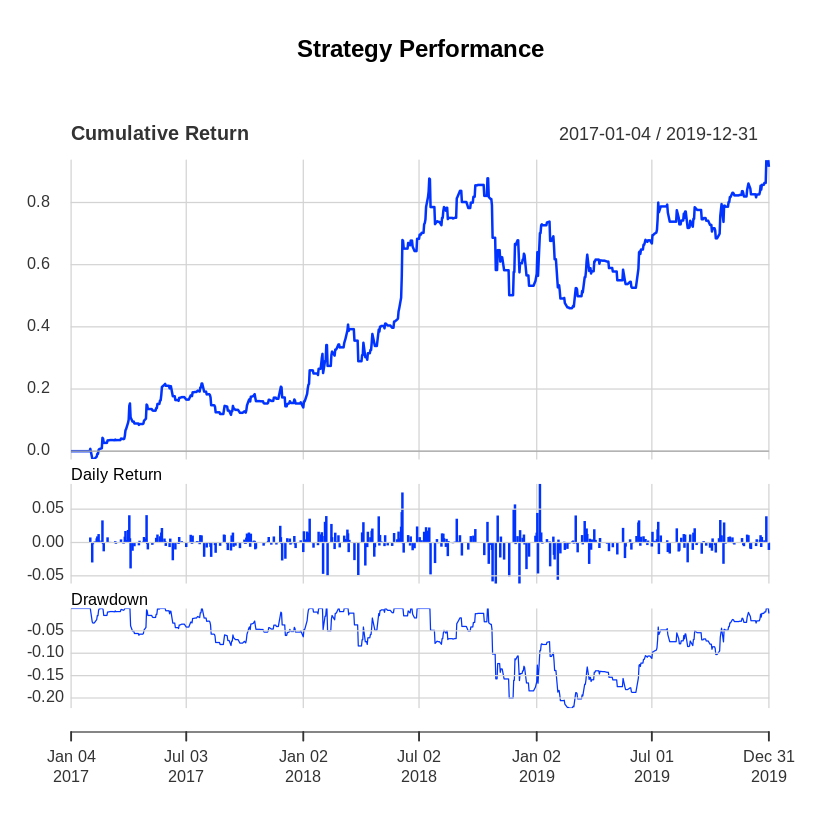

In [16]:
ret <- Return.calculate(equity, method = "log")
tail(ret)
charts.PerformanceSummary(ret, colorset = bluefocus, main = "Strategy Performance")

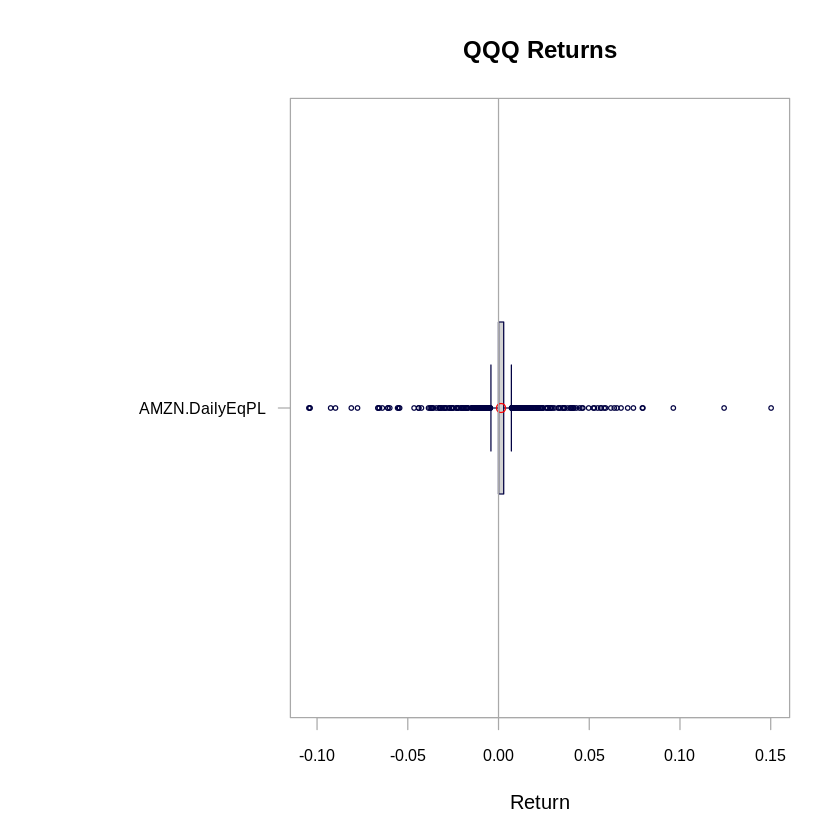

In [17]:
rets <- PortfReturns(Account = account.st)
chart.Boxplot(rets, main = "QQQ Returns", colorset= rich10equal)

In [18]:
table.Drawdowns(rets, top=10)

From,Trough,To,Depth,Length,To Trough,Recovery
<date>,<date>,<date>,<dbl>,<dbl>,<dbl>,<dbl>
2018-07-19,2019-02-22,2019-12-27,-0.3726,364,150,214
2018-03-14,2018-03-29,2018-05-10,-0.1135,41,12,29
2017-07-31,2017-09-11,2018-01-12,-0.0966,116,30,86
2017-04-07,2017-04-20,2017-05-23,-0.0671,32,9,23
2018-02-09,2018-02-09,2018-02-26,-0.0663,11,1,10
2018-02-02,2018-02-02,2018-02-07,-0.0609,4,1,3
2017-06-01,2017-06-21,2017-07-27,-0.0535,40,15,25
2018-06-07,2018-06-25,2018-06-29,-0.0362,17,13,4
2017-02-06,2017-02-07,2017-02-21,-0.0322,11,2,9


In [19]:
table.CalendarReturns(rets)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,AMZN.DailyEqPL
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2017,0,0.0,0.4,0.9,0.3,0.0,-2.6,1.4,0.0,0.0,-3.2,0.4,-2.6
2018,2,-1.0,-6.6,5.5,2.4,4.1,0.0,0.4,3.8,0.0,-0.4,1.6,12.0
2019,0,0.5,0.8,0.0,-0.3,0.0,0.0,2.2,-1.4,1.7,2.2,-2.3,3.3


In [20]:
table.DownsideRisk(rets)

,AMZN.DailyEqPL
,<dbl>
Semi Deviation,0.0143
Gain Deviation,0.0208
Loss Deviation,0.0225
Downside Deviation (MAR=210%),0.0177
Downside Deviation (Rf=0%),0.0138
Downside Deviation (0%),0.0138
Maximum Drawdown,0.3726
Historical VaR (95%),-0.0277
Historical ES (95%),-0.0528


In [21]:
table.Stats(rets)

,AMZN.DailyEqPL
,<dbl>
Observations,753.0000
NAs,0.0000
Minimum,-0.1045
Quartile 1,0.0000
Median,0.0000
Arithmetic Mean,0.0014
Geometric Mean,0.0012
Quartile 3,0.0029
Maximum,0.1502


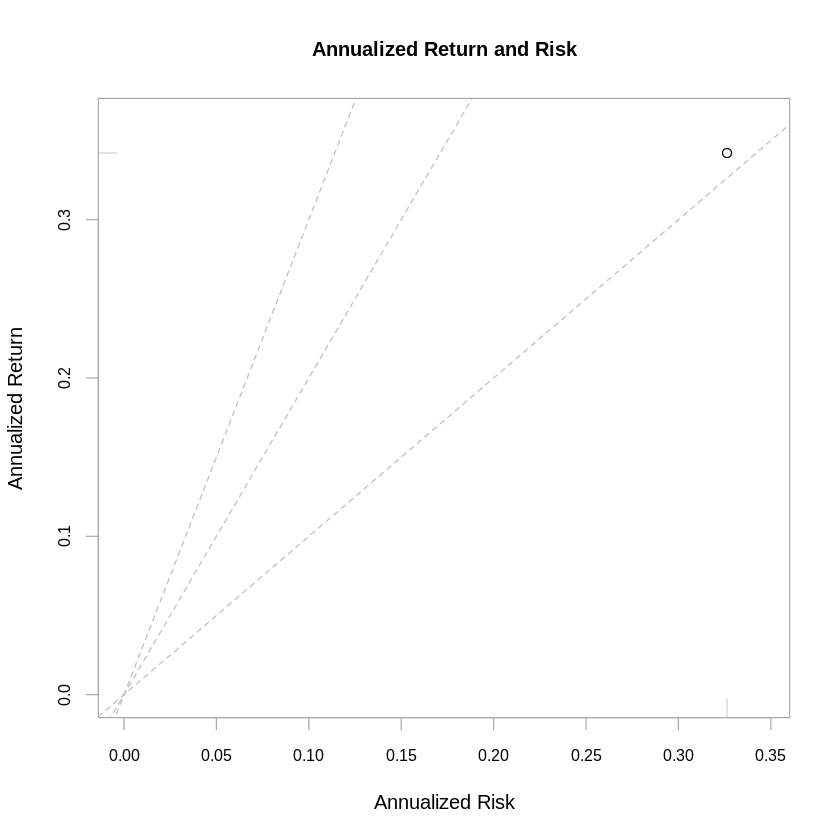

In [22]:
chart.RiskReturnScatter(rets)

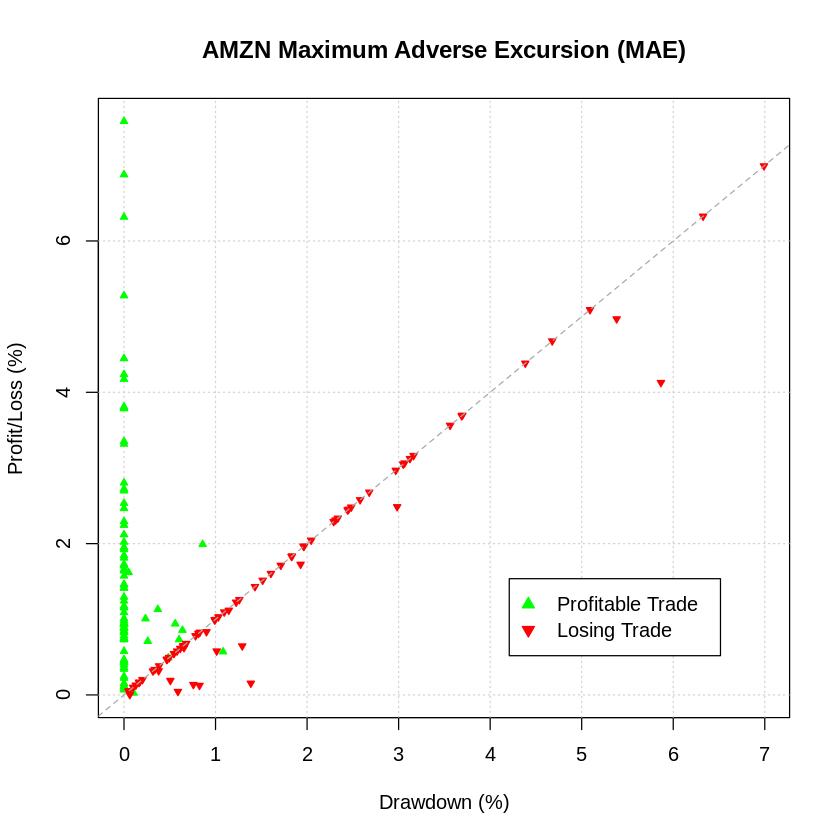

In [23]:
chart.ME(Portfolio = portfolio.st, Symbol = symbol, type = "MAE", scale = "percent")

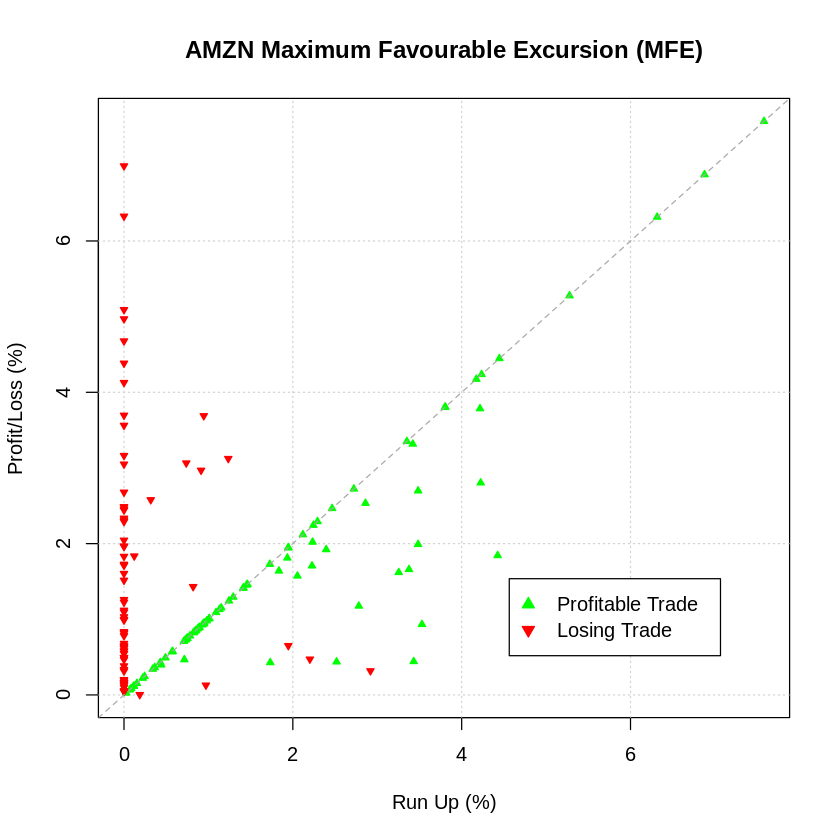

In [24]:
chart.ME(Portfolio = portfolio.st, Symbol = symbol, type = "MFE", scale = "percent")

#### Moving Average Crossover Strategy - Sample 2

* when the short term moving average crosses above the long term moving average, this indicates a buy signal
* when the short term moving average crosses below the long term moving average, it may be a good moment to sell

Reference: https://towardsdatascience.com/making-a-trade-call-using-simple-moving-average-sma-crossover-strategy-python-implementation-29963326da7a

In [25]:
# Moving Average Crossover Strategy - Sample 2
# strategy resetting
rm.strat("my strategy")
out <- initPortf(portfolio.st, symbols = symbol, initDate = start, currency = "USD")
out <- initAcct(account.st, portfolios = portfolio.st, initDate = start, currency = "USD", initEq = initEquity)
initOrders(portfolio.st, initDate = start)
strategy(strategy.st, store = TRUE)
# Indicators
out <- add.indicator(strategy.st, name = "SMA", arguments = list(x = quote(Cl(AMZN)), n = 20, maType = "SMA"), label = "SMA20periods")
out <- add.indicator(strategy.st, name = "SMA", arguments = list(x = quote(Cl(AMZN)), n = 50, maType = "SMA"), label = "SMA50periods")
out <- add.indicator(strategy.st, name = "EMA", arguments = list(x = quote(Cl(AMZN)), n = 20, maType = "EMA"), label = "EMA20periods")
out <- add.indicator(strategy.st, name = "EMA", arguments = list(x = quote(Cl(AMZN)), n = 50, maType = "EMA"), label = "EMA50periods")
# Signals
#out <- add.signal(strategy.st, name = "sigCrossover", arguments = list(columns = c("SMA20periods", "SMA50periods"), relationship = "gte", cross = TRUE), label = "buy")
#out <- add.signal(strategy.st, name = "sigCrossover", arguments = list(columns = c("SMA20periods", "SMA50periods"), relationship = "lte", cross = TRUE), label = "sell")
out <- add.signal(strategy.st, name = "sigCrossover", arguments = list(columns = c("EMA20periods", "EMA50periods"), relationship = "gte", cross = TRUE), label = "buy2")
out <- add.signal(strategy.st, name = "sigCrossover", arguments = list(columns = c("EMA20periods", "EMA50periods"), relationship = "lte", cross = TRUE), label = "sell2")
# Rules
out <- add.rule(strategy.st, name = 'ruleSignal', arguments = list(sigcol = "buy2", sigval = TRUE, orderqty = 100, ordertype = 'market', orderside = 'long'), type = 'enter')
out <- add.rule(strategy.st, name = 'ruleSignal', arguments = list(sigcol = "sell2", sigval = TRUE, orderqty = 'all', ordertype = 'market', orderside = 'long'), type = 'exit')
#out <- add.rule(strategy.st, name = 'ruleSignal', arguments = list(sigcol = "sell2", sigval = TRUE, orderqty = -100, ordertype = 'market', orderside = 'short'), type = 'enter')
#out <- add.rule(strategy.st, name = 'ruleSignal', arguments = list(sigcol = "buy2", sigval = TRUE, orderqty = 'all', ordertype = 'market', orderside = 'short'), type = 'exit')

[1] "2017-10-16 00:00:00 AMZN 100 @ 1002.940002"
[1] "2018-10-16 00:00:00 AMZN -100 @ 1760.949951"
[1] "2019-02-01 00:00:00 AMZN 100 @ 1718.72998"
[1] "2019-02-13 00:00:00 AMZN -100 @ 1638.01001"
[1] "2019-03-04 00:00:00 AMZN 100 @ 1671.72998"
[1] "2019-06-06 00:00:00 AMZN -100 @ 1738.5"
[1] "2019-06-14 00:00:00 AMZN 100 @ 1870.300049"
[1] "2019-08-08 00:00:00 AMZN -100 @ 1793.400024"
[1] "2019-12-27 00:00:00 AMZN 100 @ 1868.77002"


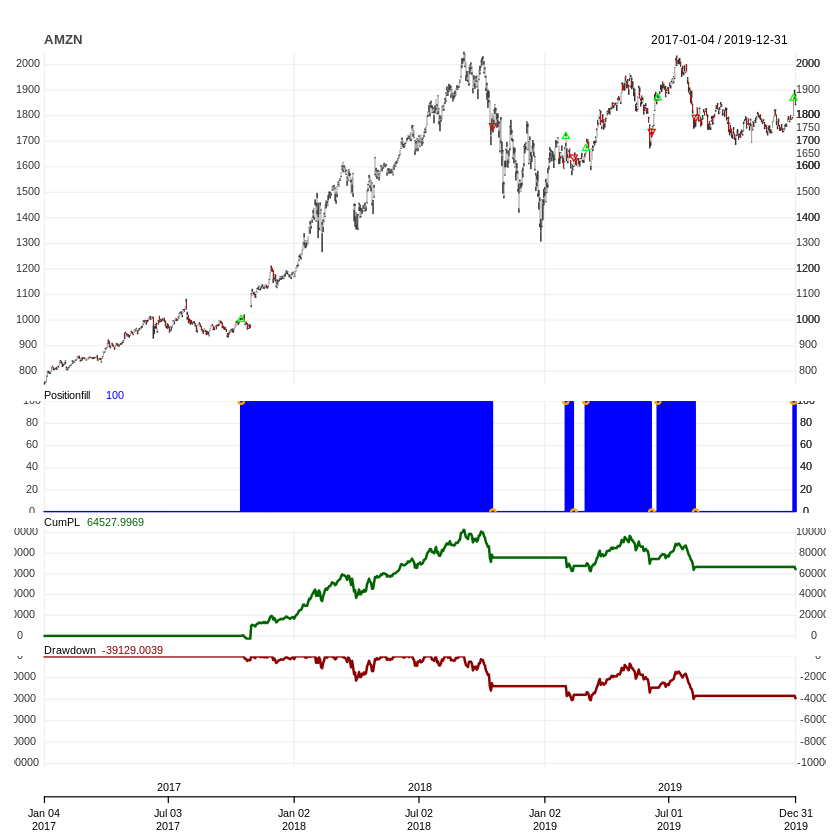

In [26]:
# backtesting
applyStrategy(strategy.st, portfolios=portfolio.st)
out <- updatePortf(portfolio.st)
dateRange <- time(getPortfolio(portfolio.st)$summary)[-1]
out <- updateAcct(portfolio.st, dateRange)
out <- updateEndEq(account.st)
chart.Posn(portfolio.st, Symbol=symbol) #, TA=c("add_SMA(n=20,col='red')"))

In [27]:
tstats <- tradeStats(portfolio.st, use="trades", inclZeroDays=FALSE)
data.frame(t(tstats))

,AMZN
,<chr>
Portfolio,my strategy
Symbol,AMZN
Num.Txns,9
Num.Trades,5
Net.Trading.PL,64528
Avg.Trade.PL,12905.6
Med.Trade.PL,-2188
Largest.Winner,75800.99
Largest.Loser,-8071.997


In [28]:
#install.packages("magrittr") # package installations are only needed the first time you use it
#install.packages("dplyr")    # alternative installation of the %>%
#library(magrittr) # needs to be run every time you start R and want to use %>%
#library(dplyr)    # alternatively, this also loads %>%
trades <- tstats %>%
    mutate(Trades = Num.Trades, 
        Win.Percent = Percent.Positive, 
        Loss.Percent = Percent.Negative, 
        WL.Ratio = Percent.Positive/Percent.Negative) %>%
    select(Trades, Win.Percent, Loss.Percent, WL.Ratio)
data.frame(t(trades))

,t.trades.
,<dbl>
Trades,5.0000000
Win.Percent,40.0000000
Loss.Percent,60.0000000
WL.Ratio,0.6666667


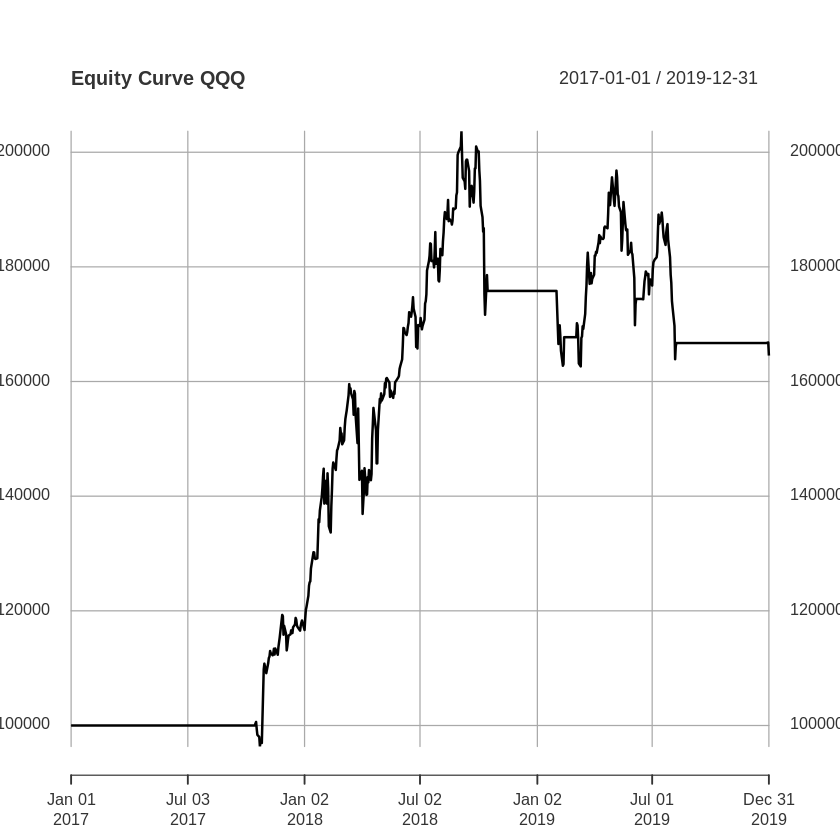

In [29]:
a <- getAccount(account.st)
equity <- a$summary$End.Eq
plot(equity, main = "Equity Curve QQQ")

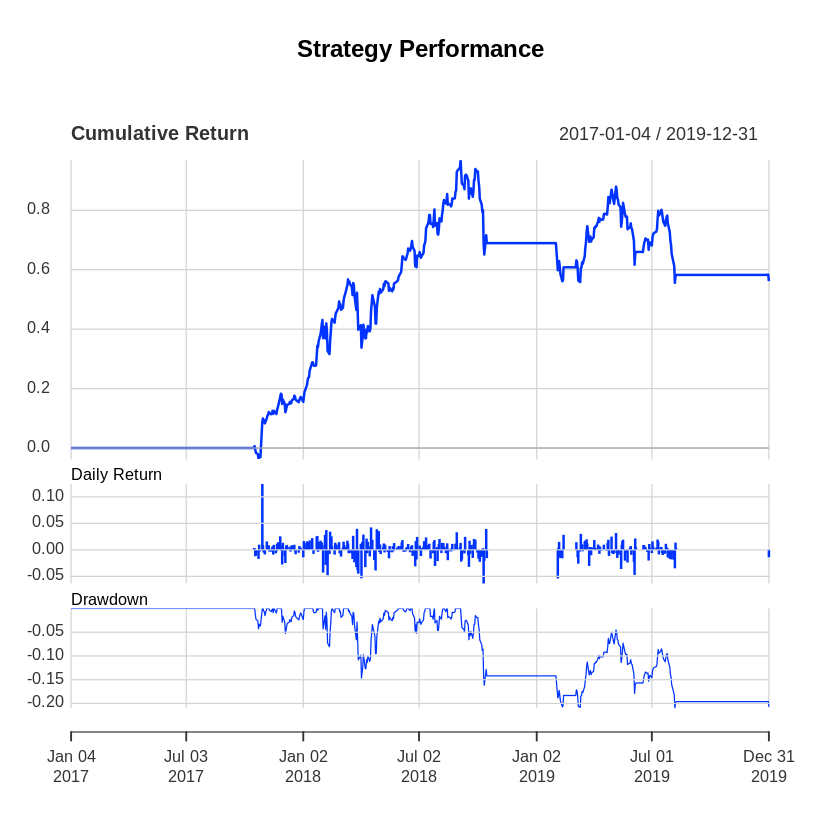

In [30]:
ret <- Return.calculate(equity, method = "log")
charts.PerformanceSummary(ret, colorset = bluefocus, main = "Strategy Performance")

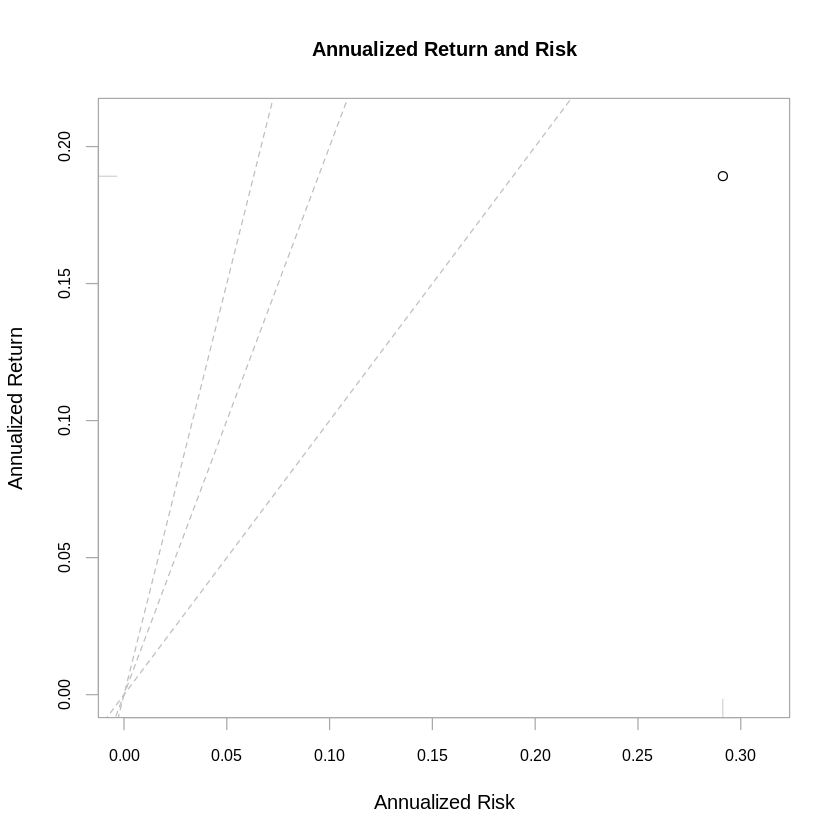

In [31]:
rets <- PortfReturns(Account = account.st)
chart.RiskReturnScatter(rets)